In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib widget

In [2]:
# open a file, where you stored the pickled data
file = open('../demo/segments_pcd', 'rb')

# dump information to that file
observation_history = pickle.load(file)

# close the file
file.close()

In [3]:
print(observation_history[1])

{'seg_id': 202, 'seg_pcd': array([[ 449.29943329, -253.4348751 ,    4.3225453 ],
       [ 452.00349218, -253.21127667,    4.6351798 ],
       [ 450.52501741, -253.30828341,    4.54683235],
       ...,
       [ 451.75302359, -253.31212112,    4.72115028],
       [ 449.59489888, -253.35901213,    4.31743329],
       [ 450.28359521, -253.39850026,    4.60607356]])}


In [ ]:
dataset = []
for obs in observation_history:
    # print(obs["seg_id"])
    if obs["seg_id"] in [5, 75, 102, 120, 149, 190, 238, 255]:
        print(obs["seg_id"])
        dataset.append(obs["seg_pcd"])

In [4]:
print(dataset[0].shape)
data = dataset[0]

(1381, 3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


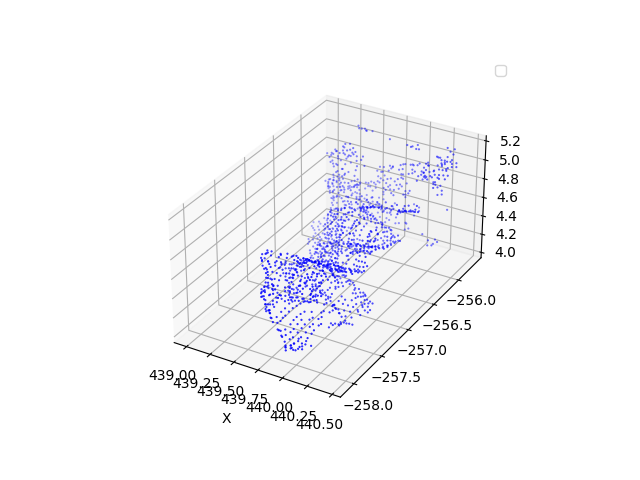

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(data[:, 0], data[:, 1], data[:, 2], 
            zdir='z', c= 'blue', s=0.3)
ax1.set_aspect('equal')
ax1.set_xlabel("X")
ax1.legend()

In [6]:
import torch
from equiv_reg import misc, config
from equiv_reg.checkpoints import CheckpointIO
from equiv_reg.transforms import apply_rot, gen_randrot
from equiv_reg.register_utils import *
from torch.nn import functional as F

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
equireg_path = "/home/lucas/Documents/GitLab/dmot/sparse_mapping/equivreg/"
cfg = misc.load_config(equireg_path + 'configs/test/reg_ideal.yaml')

is_cuda = (torch.cuda.is_available())
device = torch.device("cuda" if is_cuda else "cpu")
out_dir, gen_dir = config.cfg_f_out_test(cfg)

model = config.cfg_model(cfg, device)
checkpointio = CheckpointIO(model, checkpoint_dir=out_dir)
checkpointio.load(cfg['testing']['model_file'])

In [ ]:
model.eval()

In [28]:
# data = data/5
xyz = np.mgrid[439:450:0.1, -260:-250:0.1, 3.5:6:0.1].reshape(3,-1).T

In [10]:
import random

In [12]:
xrange = (439.0, 455.0)
yrange = (-260.0, -250.0)
zrange = (3.5, 6.0)

points = []

[ points.append((random.uniform(*xrange), random.uniform(*yrange), random.uniform(*zrange))) for i in range(100000) ]

points = np.array(points)


In [13]:
inputs = torch.from_numpy(data).unsqueeze(dim=0).to(torch.float).to(device)
points_iou = torch.from_numpy(points).unsqueeze(dim=0).to(torch.float).to(device)
with torch.no_grad():
    p_out = model(points_iou, inputs, sample=False)


THRESHOLD = 0.3
occ_iou_hat_np = (p_out.probs >= THRESHOLD).cpu().numpy()
indices_pred = np.nonzero(occ_iou_hat_np)[1]

points_ = points_iou.to('cpu').numpy()
points_pred = points_[0, indices_pred, :]
inputs_np = inputs.to('cpu').numpy()
print(f"Shape of predicted occupied points: {points_pred.shape}")


Shape of predicted occupied points: (158, 3)


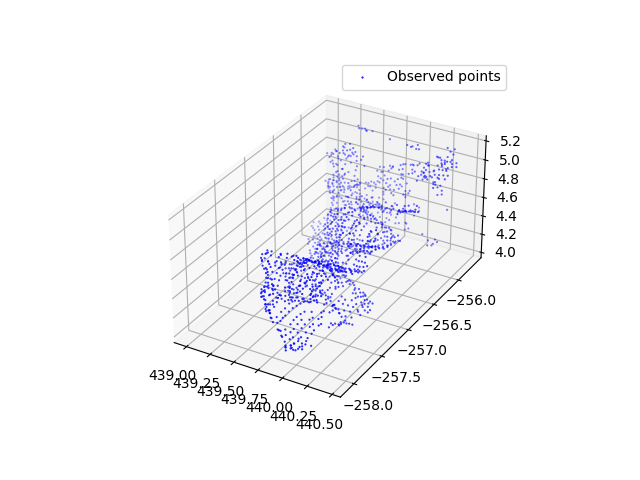

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(inputs_np[0, :, 0], inputs_np[0, :, 1], inputs_np[0, :, 2], 
            zdir='z', c= 'blue', s=0.3, label='Observed points')
# ax1.scatter(points_pred[:, 0], points_pred[:, 1], points_pred[:, 2], 
            # zdir='z', c= 'gray', s=0.1, label='Predicted occupied points')
ax1.set_aspect('equal')
ax1.legend()